In [112]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [113]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [115]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func, and_
from sqlalchemy.orm import sessionmaker


In [116]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [117]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()

# reflect the tables
print(Base.classes.keys())

['measurement', 'station']


In [118]:
# View all of the classes that automap found
reflected_classes=Base.classes.keys()
for class_name in reflected_classes:
    print(class_name)

measurement
station


In [119]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [120]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [121]:
# Find the most recent date in the data set.

#session.query(station.date).order_by(station.date.desc()).first()

inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

session.query(measurement.date).order_by(measurement.date.desc()).first()



id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


('2017-08-23',)

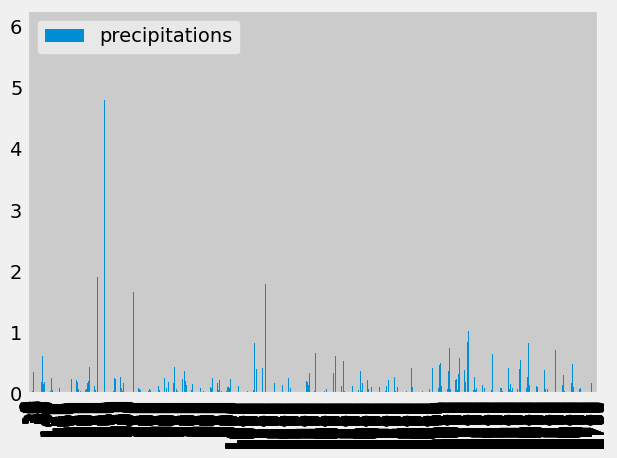

In [122]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.


# Calculate the date one year from the last date in data set.

filtered_dates = session.query(measurement.date).\
    filter(and_(measurement.date >= '2016-08-23', measurement.date <= '2017-08-23')).\
    order_by(measurement.date).all()

# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date,
       func.avg(measurement.prcp)]
may_averages = session.query(*sel).\
    group_by(measurement.date).\
    order_by(measurement.date).all()
may_averages


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(may_averages, columns=['date', 'precipitations'])

# Sort the dataframe by date
sorted_df= df.sort_values(by="date")
sorted_df



# Use Pandas Plotting with Matplotlib to plot the data

sorted_df.plot.bar()
plt.tight_layout()
plt.show()


In [123]:
# Use Pandas to calculate the summary statistics for the precipitation data
count= sorted_df["precipitations"].count()
mean= sorted_df["precipitations"].mean()
median=sorted_df["precipitations"].median()
std_dev= sorted_df["precipitations"].std()
min_value= sorted_df["precipitations"].min()
max_value= sorted_df["precipitations"].max()
FirstQ= sorted_df["precipitations"].quantile(0.25)
SecondQ= sorted_df["precipitations"].quantile(0.50)
ThirdQ= sorted_df["precipitations"].quantile(0.75)

precipitations_summary = pd.DataFrame({
    "count": [count],
    "mean": [mean],
    "median": [median],
    "std_dev": [std_dev],
    "min_value": [min_value],
    "25": [FirstQ],
    "50": [SecondQ],
    "75": [ThirdQ],
    "max_value": [max_value]
})


# Display results
precipitations_summary


,count,mean,median,std_dev,min_value,25,50,75,max_value
0,2792,0.161962,0.058333,0.345704,0.0,0.01,0.058333,0.173571,5.97


# Exploratory Station Analysis

In [144]:
# Design a query to calculate the total number of stations in the dataset

#Inspect Columns
#columns = inspector.get_columns('station')
#for c in columns:
 #  print(c['name'], c["type"])


Session = sessionmaker(bind=engine)
session = Session()
total_stations = session.query(station).count()

total_stations


9

In [145]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(
    measurement.station,
    func.count(measurement.station).label('station_count')
).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

most_active_stations

##Create a connection
#with engine.connect() as connection:
 #   # Execute the query
  #  result = connection.execute(text("SELECT * FROM station"))
    
   # # Fetch the results
   # data = result.fetchall()

# Create a connection
#with engine.connect() as connection:
    # Execute the query
 #   result = connection.execute(text("SELECT * FROM measurement"))
    
    # Fetch the results
#    data2 = result.fetchall()

#print(data)

#print(data2)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [167]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


temperature_stats= session.query(measurement.station, station.station).limit(200).all()

temperature_stats2 = session.query(
    func.min(measurement.tobs).label('min_temp'),
    func.max(measurement.tobs).label('max_temp'),
    func.avg(measurement.tobs).label('avg_temp')
).all()
temperature_stats2

[(53.0, 87.0, 73.09795396419437)]

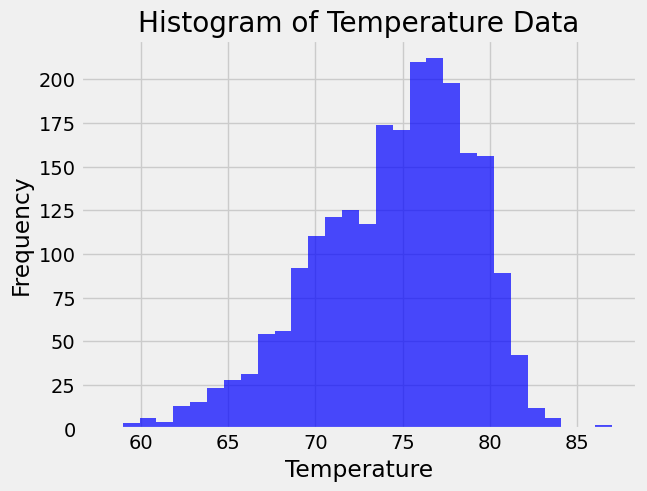

In [165]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

filtered_dates = session.query(measurement.tobs).\
    filter(and_(measurement.tobs >= '2016-08-23', measurement.tobs <= '2017-08-23')).\
    order_by(measurement.tobs).all()


sel = [measurement.tobs,
       func.avg(measurement.tobs)]
may_averages = session.query(*sel).\
    group_by(measurement.tobs).\
    order_by(measurement.tobs).all()
may_averages









#Create a connection
with engine.connect() as connection:
    # Execute the query
   result = connection.execute(text("SELECT measurement.tobs, measurement.station FROM measurement WHERE measurement.date >= '2016-08-23' AND measurement.date <= '2017-08-23';")).all()

df2 = pd.DataFrame(result, columns=["Temperature", "Station"])

df2

plt.hist(df2['Temperature'], bins=30, alpha=0.7, color='blue')  
plt.xlabel('Temperature') 
plt.ylabel('Frequency')  
plt.title('Histogram of Temperature Data')  # Title
plt.show()  


# Close Session

In [166]:
# Close Session
session.close()